In [5]:
import matplotlib.pyplot as plt
from endfiresim.wave import CWaveModelSpheric
from endfiresim.sensor import CEndfire
import numpy as np
import scipy.fft as fft

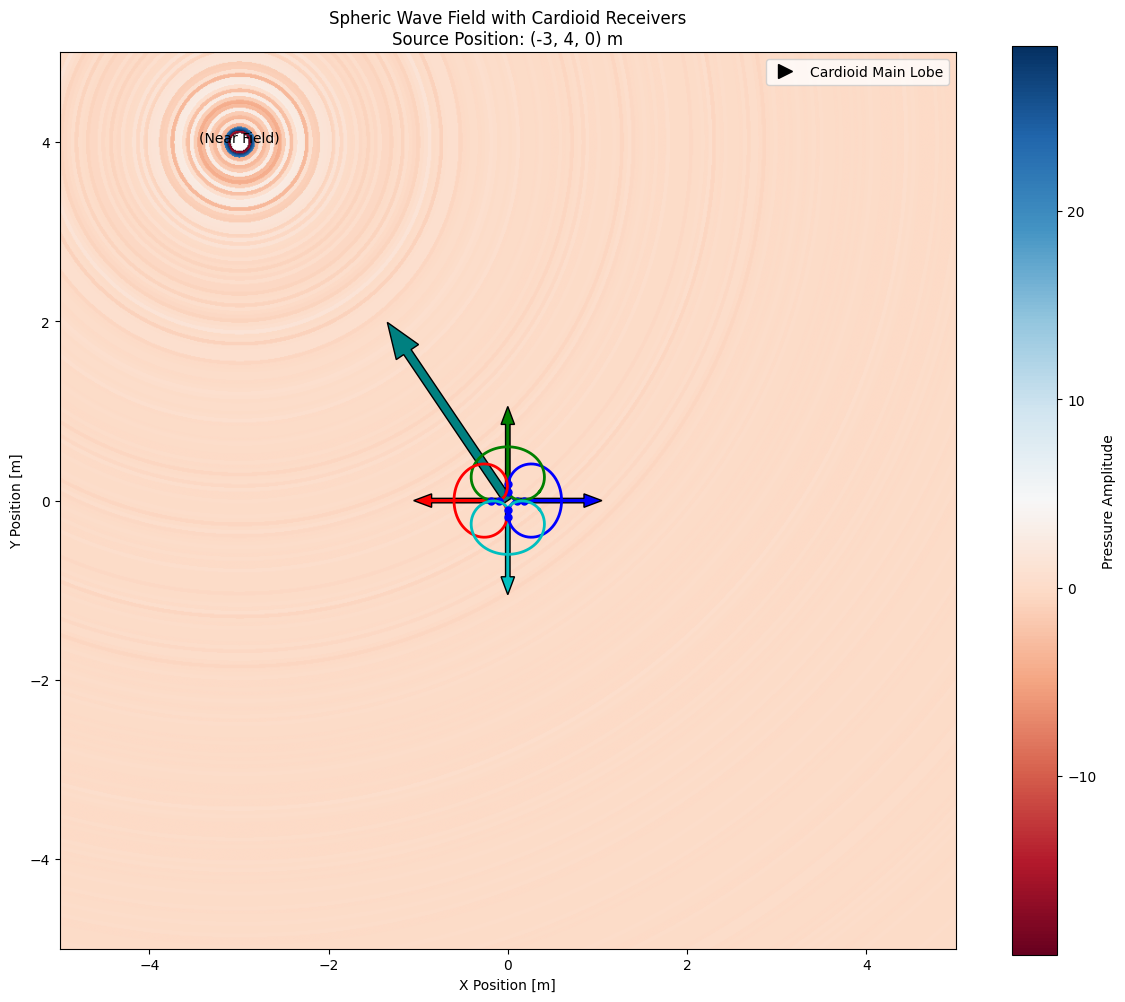

In [6]:
# Basic properties
freq = 440
tune_freq = 1000
fs = 48000
dur = 1.0
ring_r = 0.1
block_size = 1024 // 2
observation_start = int(0.5 * fs)

# Scenario objects
ts = np.arange(0, dur, 1/fs)
cardioid1 = CEndfire((ring_r, 0, 0), target_freq=tune_freq, elev=np.pi/2, azim=0)
cardioid2 = CEndfire((0, ring_r, 0), target_freq=tune_freq, elev=np.pi/2, azim=np.pi/2)
cardioid3 = CEndfire((-ring_r, 0, 0), target_freq=tune_freq, elev=np.pi/2, azim=np.pi)
cardioid4 = CEndfire((0, -ring_r, 0), target_freq=tune_freq, elev=np.pi/2, azim=3*np.pi/2)
sensors = [cardioid1, cardioid2, cardioid3, cardioid4]
sw = CWaveModelSpheric(f='wn', source_xyz=(-3, 4, 0))

# determine incident angle based on gain differences induced by cardioid
# (this only works for 4 sensors in a 90° spaced ring)
u_rmss = []
us = []
for s in sensors:
    u, _ = s.receive(sw, ts[observation_start:observation_start+block_size])
    us.append(u)
    u_rms = np.std(np.real(u))
    u_rmss.append(u_rms)

incident_angle = np.atan2(u_rmss[1] - u_rmss[3], u_rmss[0] - u_rmss[2])



# Entire wave as heatmap
x = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(x, x)
z = np.zeros_like(x)
p = sw.p(1, (x, y, z))

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(np.real(p), 
               extent=[x.min(), x.max(), y.min(), y.max()],
               cmap='RdBu', 
               origin='lower')

arrow_length = 2
ax.arrow(0, 0, 
         arrow_length*np.cos(incident_angle), arrow_length*np.sin(incident_angle),
         width=0.1, head_width=0.3, head_length=0.4,
         fc='teal', ec='k')

colors = ['b','g','r','c']
for s, c in zip(sensors, colors):
    s.to_plot(ax, color=c)

ax.set_xlabel('X Position [m]')
ax.set_ylabel('Y Position [m]')
ax.set_title(f'Spheric Wave Field with Cardioid Receivers\n'
             f'Source Position: {sw.source_xyz} m')
plt.colorbar(im, label='Pressure Amplitude')
ax.set_aspect('equal')
cardioid_arrow = plt.Line2D([0], [0], color='k', marker='>', linestyle='None',
                           markersize=10, label='Cardioid Main Lobe')
ax.legend(handles=[cardioid_arrow])
ax.annotate("(Near Field)", sw.source_xyz[:2], ha="center")

plt.tight_layout()
plt.show()